<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/SetFit_Dec1_SJ_NoEmpath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get necessary packages

In [3]:
#!pip install setfit
!pip install datasets
!pip install setfit[optuna] matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.7 MB/s 
     |████████████████████████████████| 182 kB 89.3 MB/s 
     |████████████████████████████████| 212 kB 86.6 MB/s 
     |████████████████████████████████| 115 kB 91.9 MB/s 
     |████████████████████████████████| 127 kB 88.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 69 kB 8.6 MB/s 
     |████████████████████████████████| 362 kB 29.9 MB/s 
     |████████████████████████████████| 348 kB 91.1 MB/s 
     |████████████████████████████████| 95 kB 5.9 MB/s 
     |████████████████████████████████| 5.8 MB 91.6 MB/s 
     |██████

In [4]:
!pip install empath
from empath import Empath
lexicon = Empath()
# Import module
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')
import collections
from collections import Counter
import spacy
nlp =spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 3.1 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57822 sha256=9cb446a15d6814f022d6690cb721d8c5b85dc011ae72afef23d65078209ca30b
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 396 kB 4.7 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=a3b79aca7de008adb0690d0c1806d8ee339814ea1dc00b883006add0a97b64a1
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import pandas as pd
import os, re
import time
import numpy as np
import pandas as pd
import io
from io import BytesIO
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,recall_score, precision_score, f1_score,matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset


In [6]:
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss

# Set Up gcp connectivity

In [7]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Dec  2 19:10:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    49W / 400W |    658MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
! ls -lrt /content/drive/MyDrive/*.json

-rw------- 1 root root 2308 Oct 13 00:53 /content/drive/MyDrive/nlpproject.json
-rw------- 1 root root 2326 Oct 31 03:37 /content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json


In [9]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json' 
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json


In [10]:
from google.cloud import storage

storage_client = storage.Client()

buckets = storage_client.list_buckets()

print('-- List of buckets in project \"' + storage_client.project + '\"')

for b in buckets:
  print(b.name)

-- List of buckets in project "pacific-castle-360400"
266csffile
w266liwc


In [11]:
#Initialize google storage
#storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')

#Print buckets available
for bucket in storage_client.list_buckets():
  print(bucket)

#Assign bucket name being used
bucket_name = '266csffile'
#bucket_name = 'w266liwc'

#Get bucket
bucket = storage_client.get_bucket(bucket_name)

# #Show list of files in bucket and list the files
# filelist = list(bucket.list_blobs(prefix=''))
# for name in filelist:
#   print(name.name)

<Bucket: 266csffile>
<Bucket: w266liwc>


In [12]:
def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

In [13]:
#Create dictonary to transform MBTI type into multiclass value from 0 to 15
valid_MBTI = {'ISTJ': 0, 'INTJ': 1, 'ESTJ': 2, 'ENTJ': 3, 'ENTP': 4, 'INTP': 5, \
              'ISTP': 6, 'ESTP': 7, 'ISFJ': 8, 'INFJ': 9, 'ESFJ': 10, \
              'ENFJ': 11, 'ENFP': 12, 'INFP': 13, 'ISFP': 14, 'ESFP': 15}

# Connect to hugging face

In [14]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


#Hyperparameter Search with feature engineering

## Training & Validation Data

In [219]:
#load training data # delete this cell later
#training 
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message']]
#get data and labels data together 
train_combined = pd.concat([train_mbti_data,train_mbti_labels],axis=1)
#map the labels to a valid class
train_combined['label']= train_combined['MBTI Type'].map(valid_MBTI)
t_dataset = Dataset.from_pandas(train_combined)
# Create samples for SetFit Training
seed=20
labels = 16
samples_per_label = 64
sampled_datasets = []
# find the number of samples per label
for i in range(labels):
    sampled_datasets.append(t_dataset.filter(lambda x: x["label"] == i).shuffle(seed=seed).select(range(samples_per_label)))

# concatenate the sampled datasets
from datasets import concatenate_datasets
train_dataset = concatenate_datasets(sampled_datasets)

#Training feature engineering
train_dataset = train_dataset.map(lambda example:{'message': example['Username']+' SEP '+
                                                    str(example['Age'])+' SEP '+
                                                    str(example['Posts'])+' SEP '+
                                                    str(example['Occupation'])+' SEP '+
                                                    "emotion scores: " + ', '.join(f'{key} {str(value)}' for key, value in NRCLex(example['message']).raw_emotion_scores.items() if value > 0) + ' SEP ' +
                                                    "pos tags: "+', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(example['message']))).items()) +' SEP ' +
                                                    example['message']})

# remove additional columns
train_dataset = train_dataset.remove_columns(["Username",'Age','Posts','Occupation','original index','MBTI Type'])

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/1024 [00:00<?, ?ex/s]

In [220]:
#validation data
add_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
add_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')
add_mbti_data = add_mbti_data[['Username','Age','Posts','Occupation','message']]


In [221]:
#get data and labels data together 
add_combined = pd.concat([add_mbti_data,add_mbti_labels],axis=1)
#map the labels to a valid class
add_combined['label']= add_combined['MBTI Type'].map(valid_MBTI)



In [222]:
add_dataset = Dataset.from_pandas(add_combined)

In [223]:
#feature engineering
add_dataset = add_dataset.map(lambda example:{'message': example['Username']+' SEP '+
                                                    str(example['Age'])+' SEP '+
                                                    str(example['Posts'])+' SEP '+
                                                    str(example['Occupation'])+' SEP '+
                                                    "emotion scores: " + ', '.join(f'{key} {str(value)}' for key, value in NRCLex(example['message']).raw_emotion_scores.items() if value > 0) + ' SEP ' +
                                                    "pos tags: "+', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(example['message']))).items()) +' SEP ' +
                                                    example['message']})

# remove additional columns
add_dataset = add_dataset.remove_columns(["Username",'Age','Posts','Occupation','original index','MBTI Type'])


  0%|          | 0/200000 [00:00<?, ?ex/s]

In [224]:
add_dataset

Dataset({
    features: ['message', 'label'],
    num_rows: 200000
})

# Round 3 at SetFit with mpnet v2 for comparision with BERT multiheaded attention model ..removing Empath

### Round3 Set the model

In [225]:

# model specfic hyperparameters
def r3_model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 10) #10 iterations
    solver = params.get("solver", "liblinear")
    model_id = params.get("model_id", "sentence-transformers/all-mpnet-base-v2")
    model_params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained(model_id, **model_params)

# training hyperparameters
def r3_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 2),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16]),
        "num_iterations": trial.suggest_categorical("num_iterations", [10,20]),
        "seed": trial.suggest_int("seed", 1, 40),
        "max_iter": trial.suggest_int("max_iter", 50, 100),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
        "model_id": trial.suggest_categorical(
            "model_id",
            [
                "sentence-transformers/all-mpnet-base-v2",
            ],
        ),
    }

### Round3 Set the hyper parameter trainer

In [226]:
r3_hyp_trainer = SetFitTrainer(
    train_dataset=train_dataset,
    eval_dataset=add_dataset,
    model_init=r3_model_init,
    column_mapping={"message": "text", "label": "label"},
)

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


### Round3 Run the hyperparameter search

In [227]:
r3_best_run = r3_hyp_trainer.hyperparameter_search(direction="maximize", hp_space=r3_hp_space, n_trials=10)

[I 2022-12-02 09:50:51,428] A new study created in memory with name: no-name-fb4f2818-b661-4227-8834-e0e095960dce
Trial: {'learning_rate': 2.7329275846361715e-05, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 10, 'seed': 23, 'max_iter': 67, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 1
  Total optimization steps = 5120
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****


[I 2022-12-02 10:11:27,201] Trial 0 finished with value: 0.73713 and parameters: {'learning_rate': 2.7329275846361715e-05, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 10, 'seed': 23, 'max_iter': 67, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.73713.
Trial: {'learning_rate': 3.2955240190021418e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'seed': 32, 'max_iter': 95, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 1
  Total optimization steps = 5120
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 10:41:43,625] Trial 1 finished with value: 0.618245 and parameters: {'learning_rate': 3.2955240190021418e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'seed': 32, 'max_iter': 95, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.73713.
Trial: {'learning_rate': 3.687944184077547e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 10, 'seed': 30, 'max_iter': 98, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 1
  Total optimization steps = 2560
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 11:01:07,330] Trial 2 finished with value: 0.593025 and parameters: {'learning_rate': 3.687944184077547e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 10, 'seed': 30, 'max_iter': 98, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.73713.
Trial: {'learning_rate': 6.7645116610004515e-06, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 10, 'seed': 11, 'max_iter': 75, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 1
  Total optimization steps = 1280
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1280 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 11:20:35,331] Trial 3 finished with value: 0.584595 and parameters: {'learning_rate': 6.7645116610004515e-06, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 10, 'seed': 11, 'max_iter': 75, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 0 with value: 0.73713.
Trial: {'learning_rate': 8.932130805562717e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 28, 'max_iter': 72, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 2
  Total optimization steps = 5120
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 12:57:11,611] Trial 4 finished with value: 0.7657 and parameters: {'learning_rate': 8.932130805562717e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 28, 'max_iter': 72, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 4 with value: 0.7657.
Trial: {'learning_rate': 2.6534743776916513e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 10, 'seed': 14, 'max_iter': 57, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 1
  Total optimization steps = 2560
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 13:16:34,035] Trial 5 finished with value: 0.585935 and parameters: {'learning_rate': 2.6534743776916513e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 10, 'seed': 14, 'max_iter': 57, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 4 with value: 0.7657.
Trial: {'learning_rate': 1.5126113990258064e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'seed': 32, 'max_iter': 73, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hu

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 13:46:52,839] Trial 6 finished with value: 0.564345 and parameters: {'learning_rate': 1.5126113990258064e-06, 'num_epochs': 1, 'batch_size': 8, 'num_iterations': 20, 'seed': 32, 'max_iter': 73, 'solver': 'liblinear', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 4 with value: 0.7657.
Trial: {'learning_rate': 4.8142327506313225e-06, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 20, 'seed': 2, 'max_iter': 74, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 1
  Total optimization steps = 10240
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10240 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 14:19:42,766] Trial 7 finished with value: 0.70255 and parameters: {'learning_rate': 4.8142327506313225e-06, 'num_epochs': 1, 'batch_size': 4, 'num_iterations': 20, 'seed': 2, 'max_iter': 74, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 4 with value: 0.7657.
Trial: {'learning_rate': 7.038948865893921e-06, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10, 'seed': 2, 'max_iter': 91, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 20480
  Num epochs = 2
  Total optimization steps = 2560
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 15:12:15,139] Trial 8 finished with value: 0.739705 and parameters: {'learning_rate': 7.038948865893921e-06, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 10, 'seed': 2, 'max_iter': 91, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 4 with value: 0.7657.
Trial: {'learning_rate': 1.2038723633196705e-06, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 20, 'seed': 8, 'max_iter': 63, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}
model_head.pkl not found on HuggingFace Hub

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2560 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Applying column mapping to evaluation dataset
***** Running evaluation *****
[I 2022-12-02 15:42:46,548] Trial 9 finished with value: 0.6022 and parameters: {'learning_rate': 1.2038723633196705e-06, 'num_epochs': 1, 'batch_size': 16, 'num_iterations': 20, 'seed': 8, 'max_iter': 63, 'solver': 'newton-cg', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}. Best is trial 4 with value: 0.7657.


### Round3 Document the best run

In [228]:
#Display the final result of the best hyperparameters that gave highest accuracy
r3_best_run

BestRun(run_id='4', objective=0.7657, hyperparameters={'learning_rate': 8.932130805562717e-05, 'num_epochs': 2, 'batch_size': 16, 'num_iterations': 20, 'seed': 28, 'max_iter': 72, 'solver': 'lbfgs', 'model_id': 'sentence-transformers/all-mpnet-base-v2'}, backend=<optuna.study.study.Study object at 0x7fcb45827d10>)

### Round3 Apply the parameters and train and evalute the model

In [229]:
r3_hyp_trainer.apply_hyperparameters(r3_best_run.hyperparameters, final_model=True)
r3_hyp_trainer.train()

r3_hyp_metrics = r3_hyp_trainer.evaluate()

print(f"model used: {r3_best_run.hyperparameters['model_id']}")
print(f"train dataset: {len(train_dataset)} samples")
print(f"accuracy: {r3_hyp_metrics['accuracy']}")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 40960
  Num epochs = 2
  Total optimization steps = 5120
  Total train batch size = 16


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5120 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


model used: sentence-transformers/all-mpnet-base-v2
train dataset: 1024 samples
accuracy: 0.763465


###Round3 Push the model to huggingface

In [230]:
r3_hyp_trainer.push_to_hub(f"r3-w266-setfit-mbti-noempath-multiclass-hypsearch-mpnet-dec1")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'push_to_hub': pass repo_path_or_name='r3-w266-setfit-mbti-noempath-multiclass-hypsearch-mpnet-dec1', repo_url=None, commit_message='Add SetFit model', organization=None, private=None, api_endpoint=None, token=None, git_user=None, git_email=None, config=None, skip_lfs_files=False as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'push_to_hub': repo_path_or_name. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Cloning https://huggingface.co/shrinivasbjoshi/r3-w266-setfit-mbti-noempath-multiclass-hypsearch-mpnet-dec1 into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.30k/418M [00:00<?, ?B/s]

Upload file model_head.pkl:   3%|3         | 3.30k/97.2k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/shrinivasbjoshi/r3-w266-setfit-mbti-noempath-multiclass-hypsearch-mpnet-dec1
   32b5000..55f73c8  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/shrinivasbjoshi/r3-w266-setfit-mbti-noempath-multiclass-hypsearch-mpnet-dec1
   32b5000..55f73c8  main -> main



'https://huggingface.co/shrinivasbjoshi/r3-w266-setfit-mbti-noempath-multiclass-hypsearch-mpnet-dec1/commit/55f73c87406db4c7689de936bff7b4cbcd42ba82'

###Round3 Import the model from hugging face
(Hyperparameter search ran overnight, model was pushed to hugging face )

In [15]:
#model import 
# importing the model from hugging face
r3_hyp_w266_setfit_mbti = SetFitModel.from_pretrained("shrinivasbjoshi/r3-w266-setfit-mbti-noempath-multiclass-hypsearch-mpnet-dec1")

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

# ###Round3 Plot confusion matirx

#####Load Test data, set up dataset & feature engineering

In [16]:
#test 
test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')
test_mbti_data = test_mbti_data[['Username','Age','Posts','Occupation','message']]

In [17]:
#get data and labels data together 
test_combined = pd.concat([test_mbti_data,test_mbti_labels],axis=1)
#map the labels to a valid class
test_combined['label']= test_combined['MBTI Type'].map(valid_MBTI)

In [18]:
# create test dataset
test_dataset = Dataset.from_pandas(test_combined)

In [19]:
test_dataset

Dataset({
    features: ['Username', 'Age', 'Posts', 'Occupation', 'message', 'original index', 'MBTI Type', 'label'],
    num_rows: 93106
})

In [20]:
test_dataset[0]

{'Username': 'laurie',
 'Age': 49.0,
 'Posts': 6072,
 'Occupation': 'nada',
 'message': 'i liked it.',
 'original index': 852132,
 'MBTI Type': 'ENFP',
 'label': 12}

In [21]:
test_dataset = test_dataset.map(lambda example:{'message': example['Username']+' SEP '+
                                                    str(example['Age'])+' SEP '+
                                                    str(example['Posts'])+' SEP '+
                                                    str(example['Occupation'])+' SEP '+
                                                    "emotion scores: " + ', '.join(f'{key} {str(value)}' for key, value in NRCLex(example['message']).raw_emotion_scores.items() if value > 0) + ' SEP ' +
                                                    "pos tags: "+', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(example['message']))).items()) +' SEP ' +
                                                    example['message']})

  0%|          | 0/93106 [00:00<?, ?ex/s]

In [22]:
test_dataset = test_dataset.remove_columns(["Username",'Age','Posts','Occupation','original index','MBTI Type'])

In [23]:
test_dataset[0]

{'message': 'laurie SEP 49.0 SEP 6072 SEP nada SEP emotion scores:  SEP pos tags: pron 2, verb 1, punct 1 SEP i liked it.',
 'label': 12}

In [24]:
test_dataset

Dataset({
    features: ['message', 'label'],
    num_rows: 93106
})

In [25]:
# #run the tests
r3_input = test_dataset['message']
r3_hyp_predictions = r3_hyp_w266_setfit_mbti.predict(r3_input)
test_labels = test_dataset['label']
nptest_labels = np.asarray(test_labels)



              precision    recall  f1-score   support

        ISTJ       0.76      0.80      0.78      1877
        INTJ       0.79      0.78      0.78     12850
        ESTJ       0.91      0.93      0.92      2243
        ENTJ       0.70      0.91      0.79      4186
        ENTP       0.67      0.72      0.70      8567
        INTP       0.85      0.68      0.76     12925
        ISTP       0.70      0.85      0.77      3576
        ESTP       0.94      0.90      0.92      1840
        ISFJ       0.71      0.88      0.79      1061
        INFJ       0.60      0.72      0.65      9275
        ESFJ       0.89      0.98      0.93      2169
        ENFJ       0.90      0.86      0.88      2920
        ENFP       0.91      0.76      0.83     11048
        INFP       0.70      0.64      0.67     12497
        ISFP       0.88      0.89      0.88      3946
        ESFP       0.71      0.96      0.82      2126

    accuracy                           0.76     93106
   macro avg       0.79   

Text(281.5, 0.5, 'True')

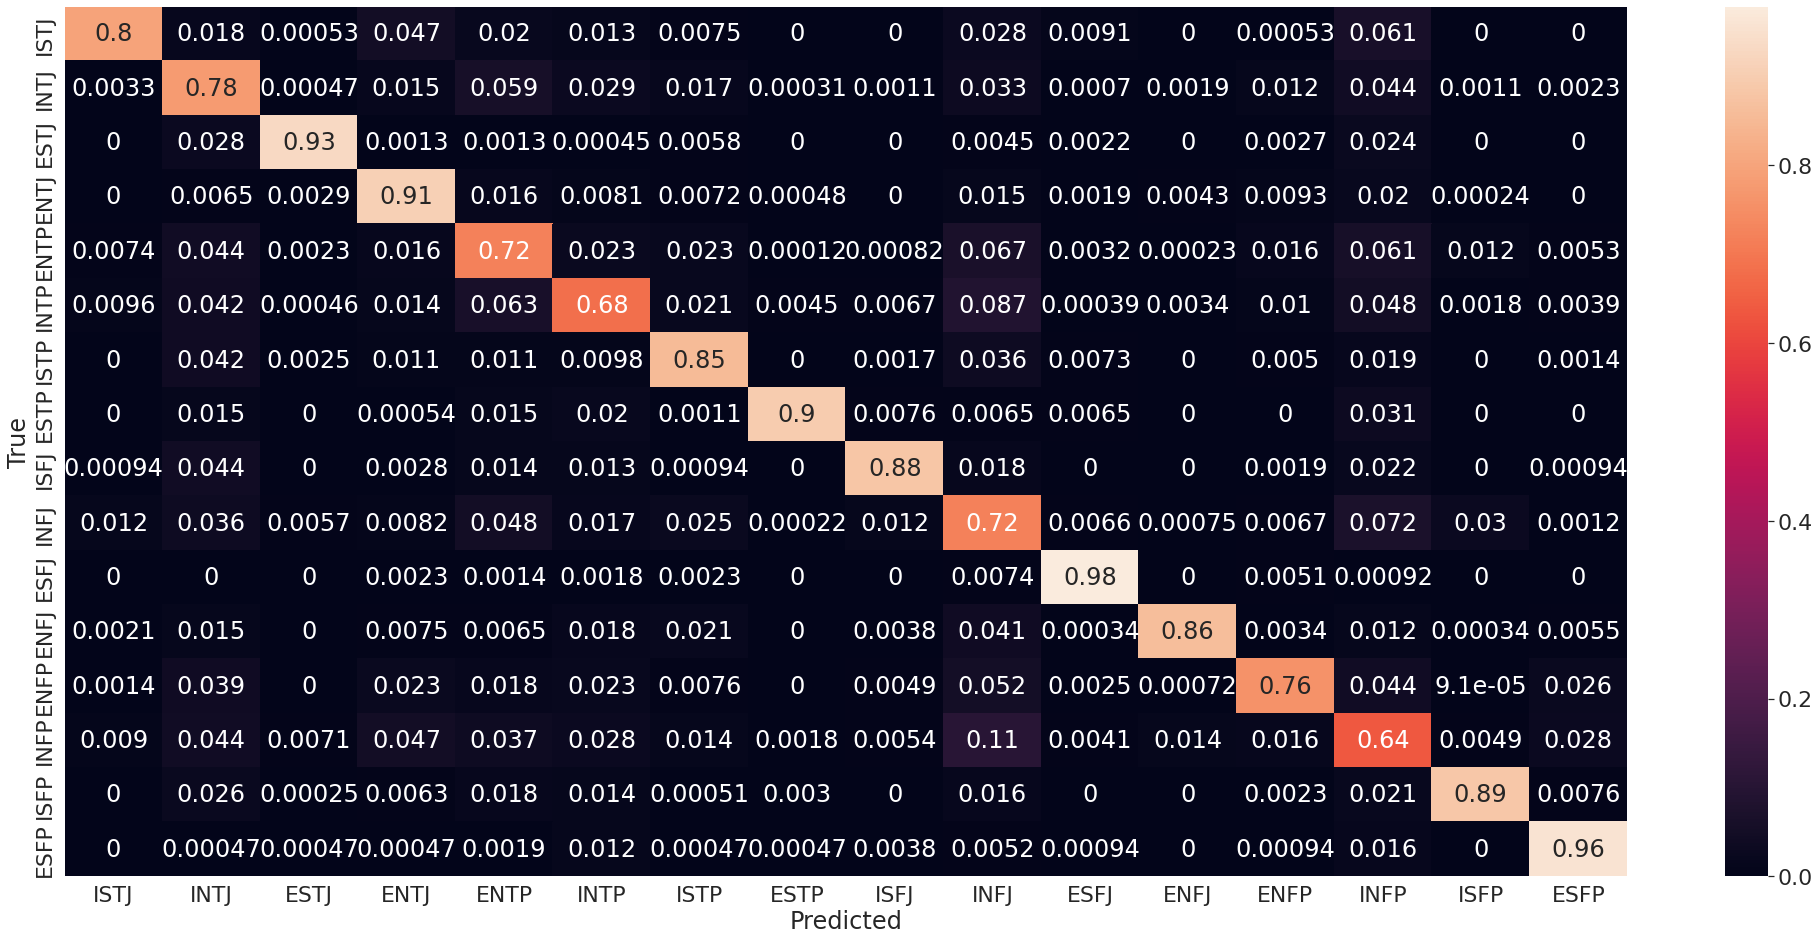

In [49]:
#plot below
print(classification_report(nptest_labels, r3_hyp_predictions,target_names=valid_MBTI))
cr_multi = classification_report(nptest_labels, r3_hyp_predictions, target_names=valid_MBTI)

cm_multi = confusion_matrix(nptest_labels, r3_hyp_predictions)
cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(35,16))
sns.heatmap(
      cm_multi, annot=True,
      xticklabels=valid_MBTI,
      yticklabels=valid_MBTI)
plt.xlabel("Predicted")
plt.ylabel("True")

# Round3 Additional Data Error Analysis

In [50]:
test_combined

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature,accurate,message_len,feature_len
1400000,laurie,49.0,6072,nada,i liked it.,852132,ENFP,12,12,laurie SEP 49.0 SEP 6072 SEP nada SEP emotion ...,True,3,23
1400001,searchingforpeace,52.0,5569,None,nope just why?,1242759,ENFJ,11,11,searchingforpeace SEP 52.0 SEP 5569 SEP None S...,True,3,27
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",61435,INTP,5,9,anonymous SEP 33.0 SEP 605 SEP None SEP emotio...,False,28,78
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,437446,INTP,5,5,eric b SEP 56.0 SEP 3620 SEP subway motorman S...,True,89,153
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,1589900,ESFJ,10,10,yama SEP 28.0 SEP 7684 SEP microbiology techni...,True,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493101,coriolis,45.0,26905,None,"a lot of things because me feel guilty, even t...",283920,INTJ,1,1,coriolis SEP 45.0 SEP 26905 SEP None SEP emoti...,True,267,329
1493102,uumlau,56.0,5517,None,you are so cute. yes you can blow an extraor...,1525910,INTJ,1,1,uumlau SEP 56.0 SEP 5517 SEP None SEP emotion ...,True,161,225
1493103,betty blue,45.0,5064,self employed,"vacuumed the whole house, ran greatest distanc...",144864,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,12,46
1493104,jeffster,46.0,6743,office manager for subway (eat fresh!),XXXXc ^?,715585,ESFP,15,15,jeffster SEP 46.0 SEP 6743 SEP office manager ...,True,2,27


In [28]:
# Merge results with data frame
test_combined['prediction'] = r3_hyp_predictions.tolist()

In [29]:
# get the feature engineered message from dataset
feature = test_dataset['message']

In [30]:
# add features backinto dataframe
test_combined['feature'] = feature

In [31]:
#now we have orignial message, user profile information, label, feature engineering message and predictions together
test_combined

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature
1400000,laurie,49.0,6072,nada,i liked it.,852132,ENFP,12,12,laurie SEP 49.0 SEP 6072 SEP nada SEP emotion ...
1400001,searchingforpeace,52.0,5569,None,nope just why?,1242759,ENFJ,11,11,searchingforpeace SEP 52.0 SEP 5569 SEP None S...
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",61435,INTP,5,9,anonymous SEP 33.0 SEP 605 SEP None SEP emotio...
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,437446,INTP,5,5,eric b SEP 56.0 SEP 3620 SEP subway motorman S...
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,1589900,ESFJ,10,10,yama SEP 28.0 SEP 7684 SEP microbiology techni...
...,...,...,...,...,...,...,...,...,...,...
1493101,coriolis,45.0,26905,None,"a lot of things because me feel guilty, even t...",283920,INTJ,1,1,coriolis SEP 45.0 SEP 26905 SEP None SEP emoti...
1493102,uumlau,56.0,5517,None,you are so cute. yes you can blow an extraor...,1525910,INTJ,1,1,uumlau SEP 56.0 SEP 5517 SEP None SEP emotion ...
1493103,betty blue,45.0,5064,self employed,"vacuumed the whole house, ran greatest distanc...",144864,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...
1493104,jeffster,46.0,6743,office manager for subway (eat fresh!),XXXXc ^?,715585,ESFP,15,15,jeffster SEP 46.0 SEP 6743 SEP office manager ...


In [32]:
# add accuracy indicator on each observation
test_combined['accurate'] = test_combined['label']== test_combined['prediction']

In [33]:
# add message length and feature lenghts to the dataframe
test_combined['message_len'] = test_combined['message'].str.split().str.len()

In [34]:
test_combined['feature_len'] = test_combined['feature'].str.split().str.len()

In [35]:
test_combined

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature,accurate,message_len,feature_len
1400000,laurie,49.0,6072,nada,i liked it.,852132,ENFP,12,12,laurie SEP 49.0 SEP 6072 SEP nada SEP emotion ...,True,3,23
1400001,searchingforpeace,52.0,5569,None,nope just why?,1242759,ENFJ,11,11,searchingforpeace SEP 52.0 SEP 5569 SEP None S...,True,3,27
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",61435,INTP,5,9,anonymous SEP 33.0 SEP 605 SEP None SEP emotio...,False,28,78
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,437446,INTP,5,5,eric b SEP 56.0 SEP 3620 SEP subway motorman S...,True,89,153
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,1589900,ESFJ,10,10,yama SEP 28.0 SEP 7684 SEP microbiology techni...,True,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493101,coriolis,45.0,26905,None,"a lot of things because me feel guilty, even t...",283920,INTJ,1,1,coriolis SEP 45.0 SEP 26905 SEP None SEP emoti...,True,267,329
1493102,uumlau,56.0,5517,None,you are so cute. yes you can blow an extraor...,1525910,INTJ,1,1,uumlau SEP 56.0 SEP 5517 SEP None SEP emotion ...,True,161,225
1493103,betty blue,45.0,5064,self employed,"vacuumed the whole house, ran greatest distanc...",144864,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,12,46
1493104,jeffster,46.0,6743,office manager for subway (eat fresh!),XXXXc ^?,715585,ESFP,15,15,jeffster SEP 46.0 SEP 6743 SEP office manager ...,True,2,27


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


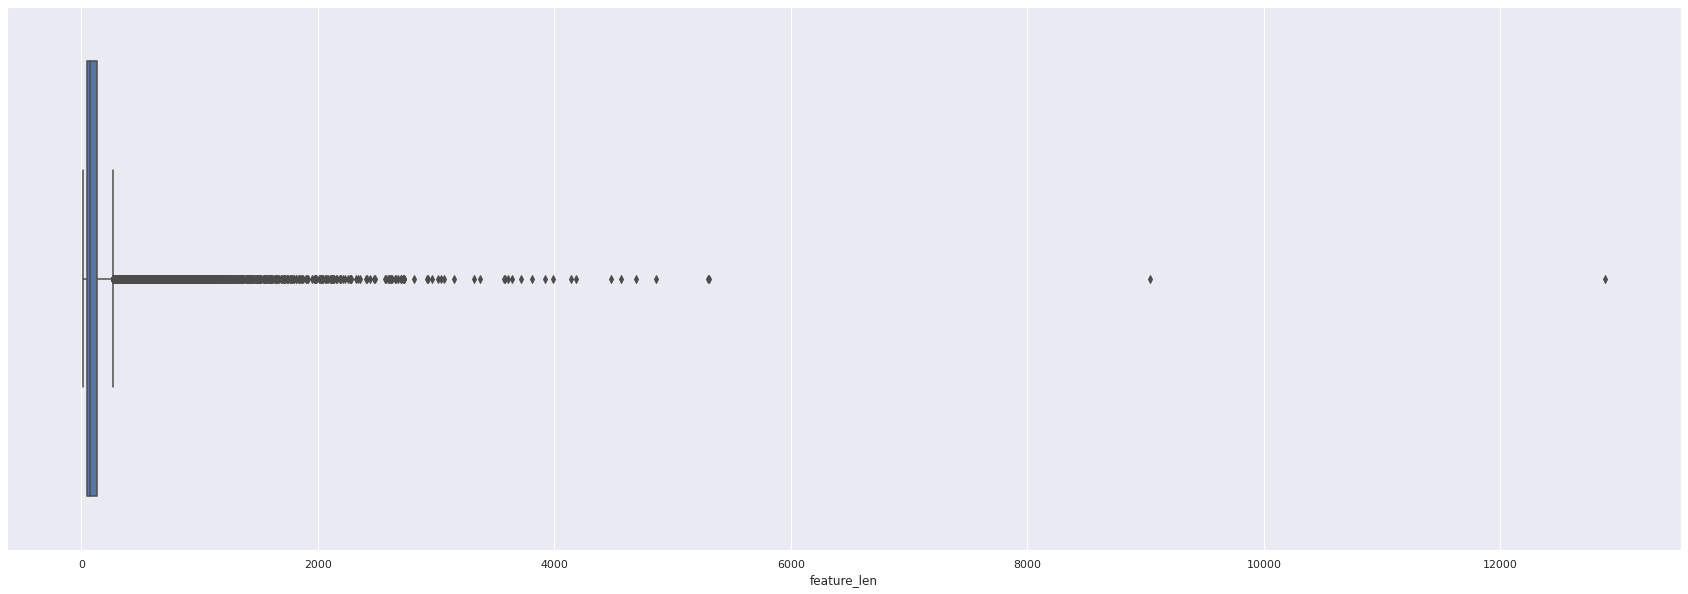

In [36]:
#check for outliars in the message length
sns.set(rc={'figure.figsize':(30,10)})
sns.boxplot(test_combined['feature_len'])

## mpnet v2 will truncate input text longer than 384 word pieces. we have lot of outliars in our additional testing dataset in terms of feature length, let us focus on feature length in 2 groups i.e <=384 and > 384



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd82f175ad0>,
      dtype=object)

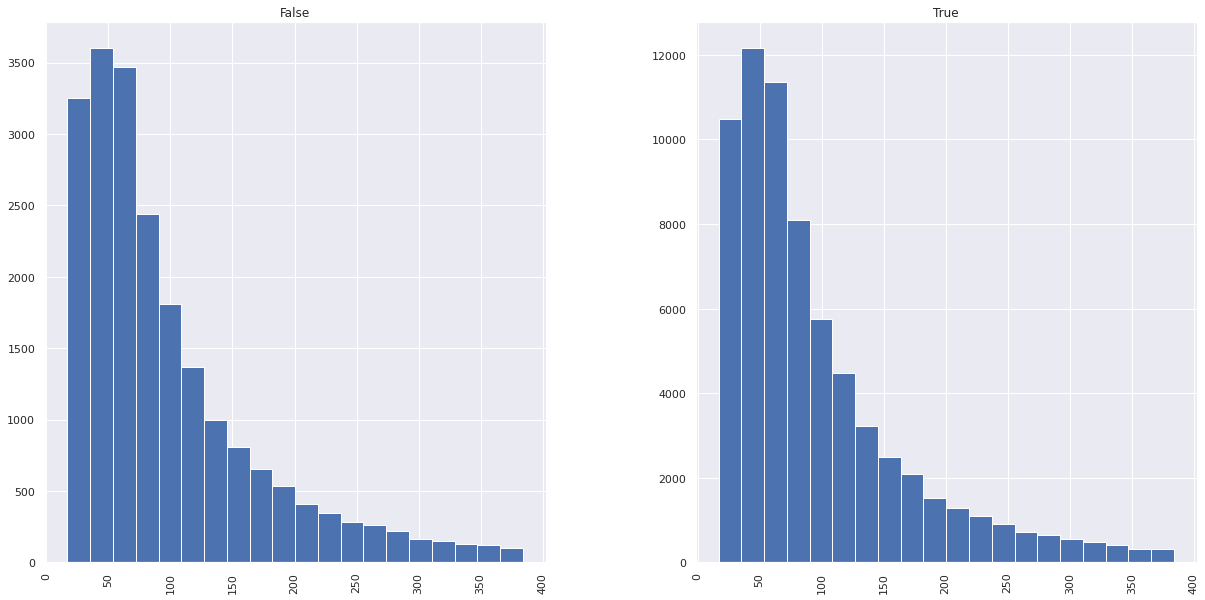

In [37]:
test_combined['feature_len'][test_combined['feature_len'] <= 384].hist(by=test_combined['accurate'],bins=20,figsize=(20,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd82f23f8d0>,
      dtype=object)

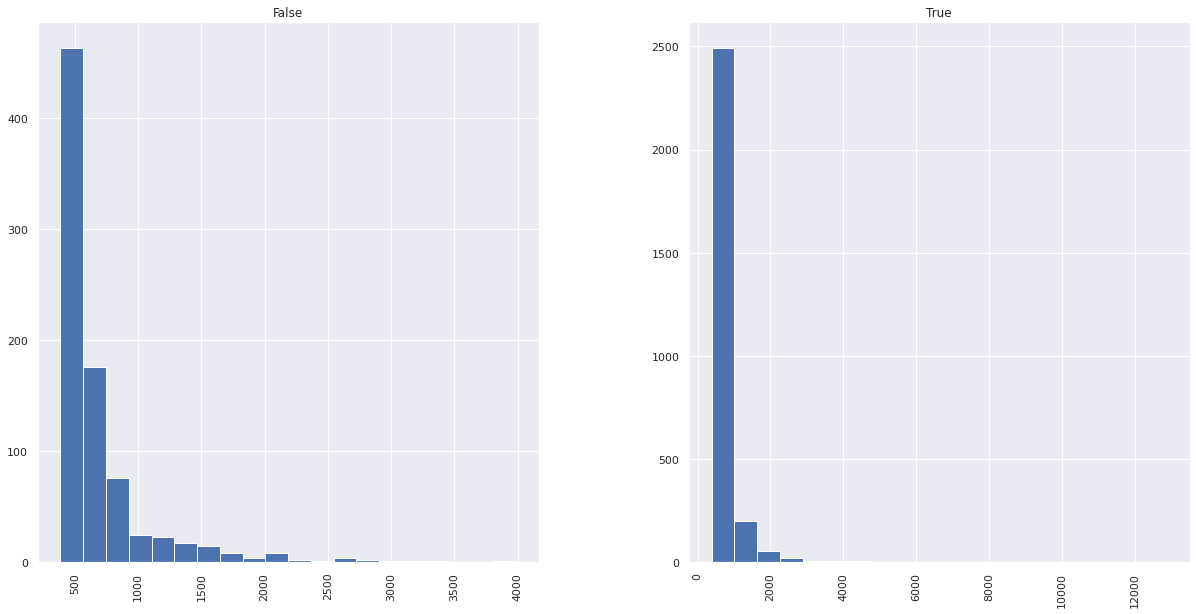

In [38]:
test_combined['feature_len'][test_combined['feature_len'] > 384].hist(by=test_combined['accurate'],bins=20,figsize=(20,10))

In [39]:
test_combined['accurate'][test_combined['feature_len'] > 384].value_counts(normalize = True)

True     0.771334
False    0.228666
Name: accurate, dtype: float64

In [40]:
test_combined['accurate'][test_combined['feature_len'] <= 384].value_counts(normalize = True)

True     0.764061
False    0.235939
Name: accurate, dtype: float64

## It does not seem like that text beyond 384 is hurting the models ability to predict. Our approach to feautre engineering for word embeddings is helping us extract signals and dimensions from the actual message in abstract way and enable us to predict

Text(0, 0.5, 'Count')

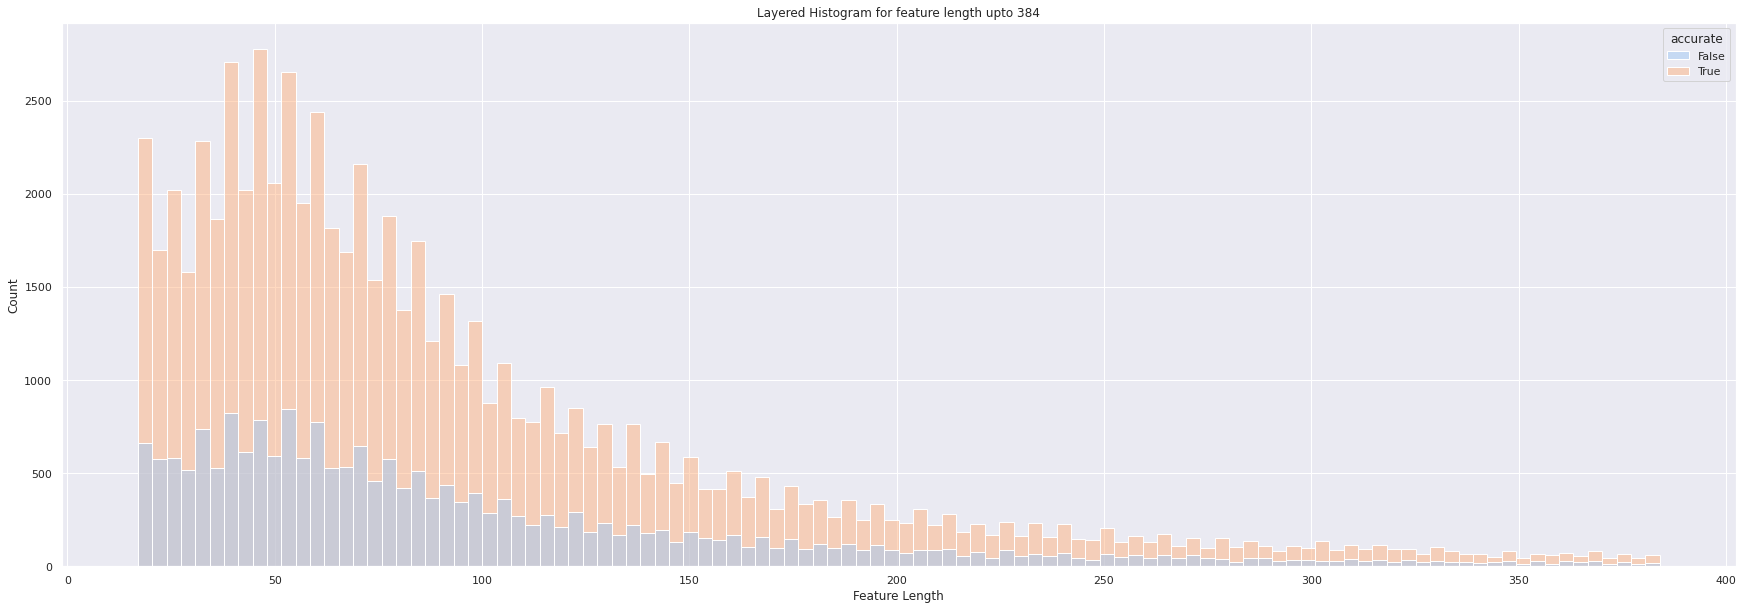

In [41]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_combined[test_combined['feature_len'] <= 384], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length upto 384")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

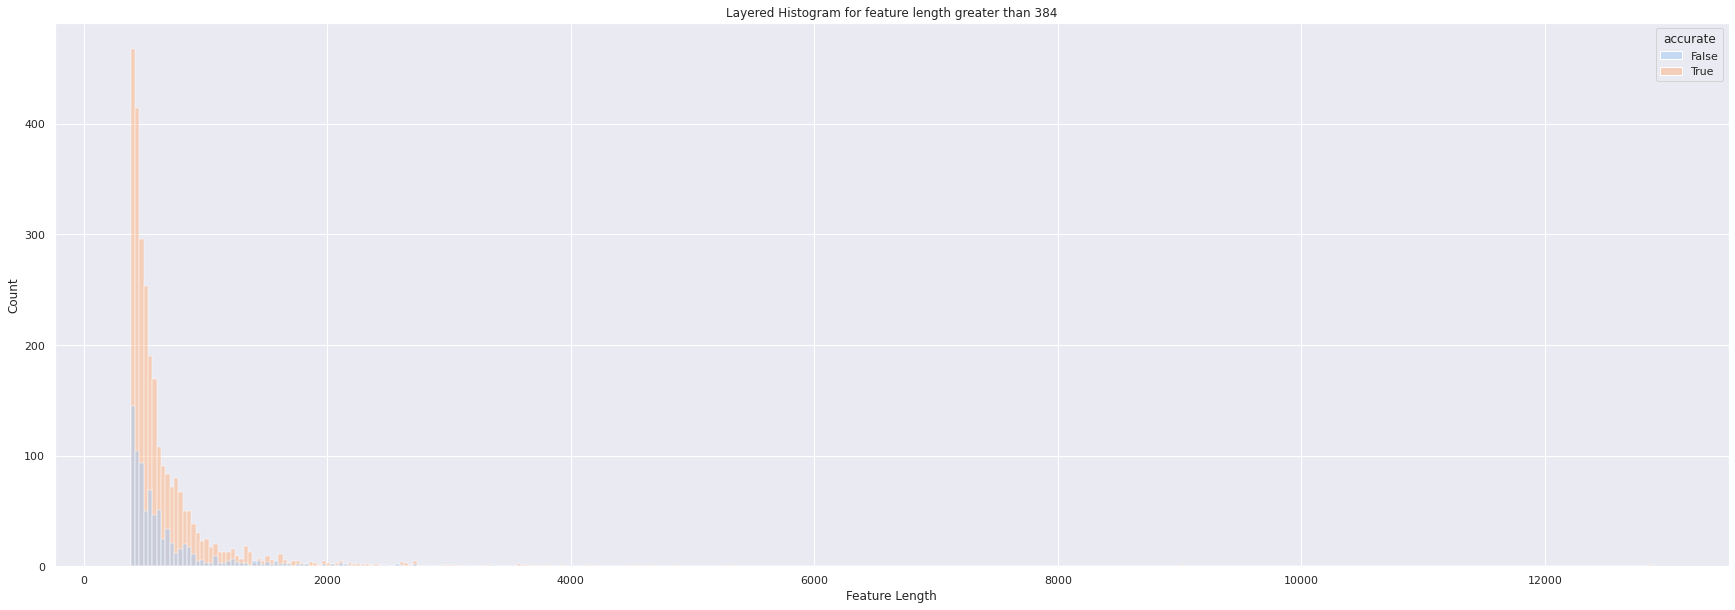

In [42]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_combined[test_combined['feature_len'] > 384 ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length greater than 384")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")

## * Our features do help to cirumvent the limit of 384 words from mpnetv2 as we can see from above that even for lengths > 384 we are mostly able to infer on correct MBTI classification

In [43]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center",fontsize=10) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left",fontsize=10)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

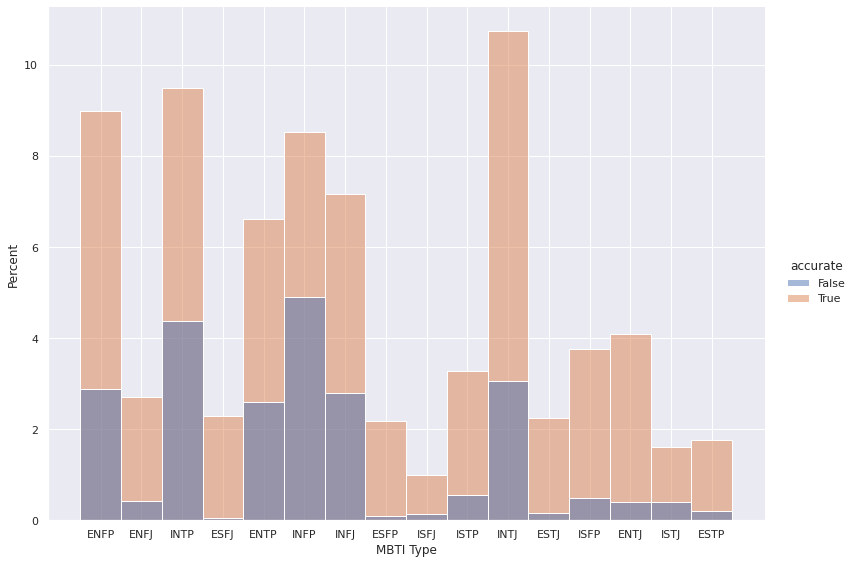

In [44]:
#let us look at percent distribution of errors per MBTI Type
sns.displot(data=test_combined, x='MBTI Type', stat='percent', hue='accurate',height=8, aspect=11/8)

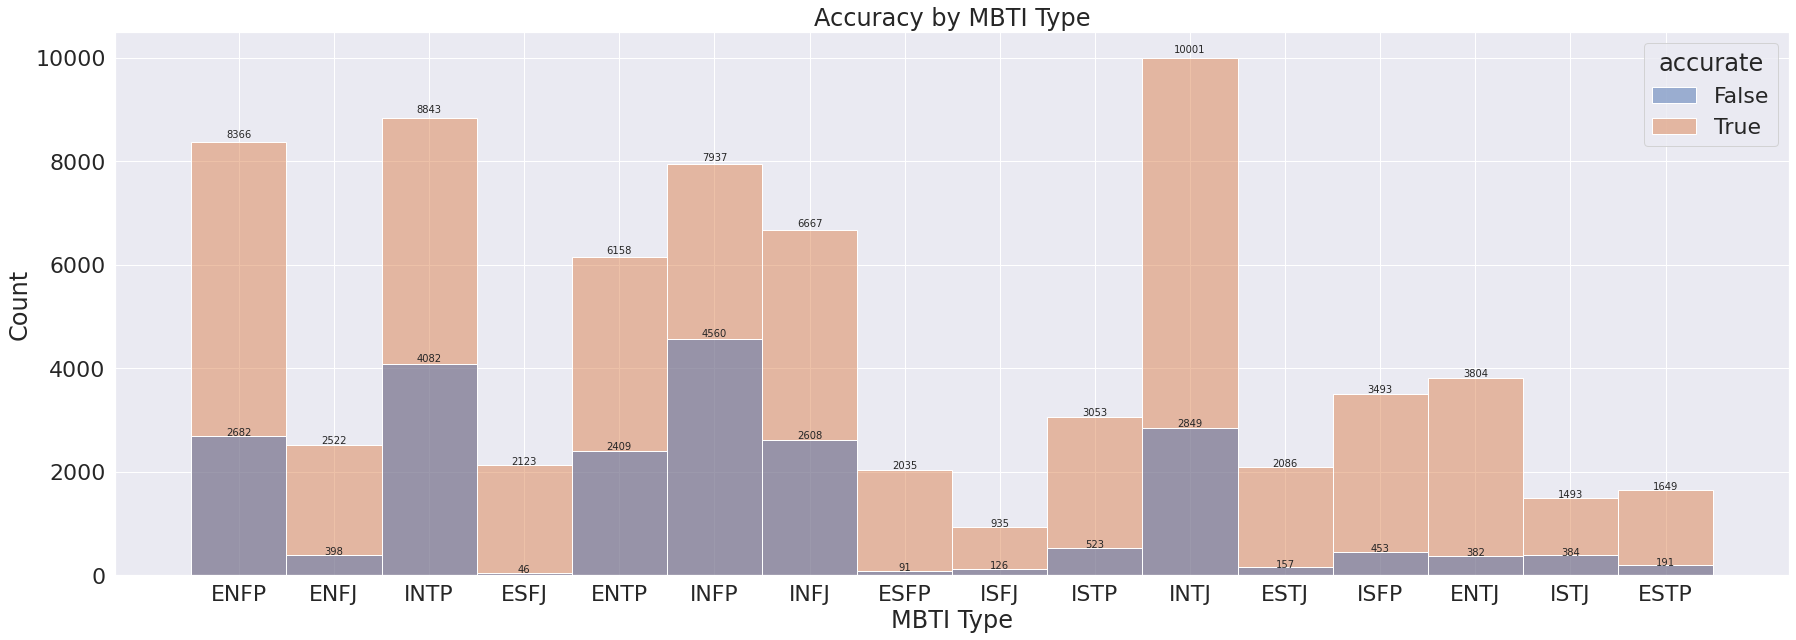

In [45]:
#plot with absolute count
f = plt.figure(figsize=(30,10))
sns.set(font_scale=2)
ax = f.add_subplot(1,1,1)
#sns.histplot(data=add_combined, x="MBTI Type", color="skyblue", label="accurate", kde=True,hue="accurate")
sns.histplot(data=test_combined, x="MBTI Type",  label="accurate", kde=False,hue="accurate")
#sns.histplot(data=add_combined, x="Posts", color="red", label="Posts", kde=True,hue="accurate")
ax.set_title("Accuracy by MBTI Type")
ax.set_xlabel("MBTI Type")
ax.set_ylabel("Count")
show_values(ax)

In [51]:
test_combined.groupby(['MBTI Type'])['accurate'].value_counts(normalize=True).unstack(level=1)

accurate,False,True
MBTI Type,,
ENFJ,0.136301,0.863699
ENFP,0.242759,0.757241
ENTJ,0.091257,0.908743
ENTP,0.281195,0.718805
ESFJ,0.021208,0.978792
ESFP,0.042803,0.957197
ESTJ,0.069996,0.930004
ESTP,0.103804,0.896196
INFJ,0.281186,0.718814


Top 5  errors are in INFP,ENTP,INTP,INFJ,ENFP

## *Most of the errornous predictions are for INFP,ENTP,INTP,INFJ,ENFP
#### Let us drill down into those

In [52]:
top_5=['INFP','ENTP','INTP','INFJ','ENFP']

Text(0, 0.5, 'Count')

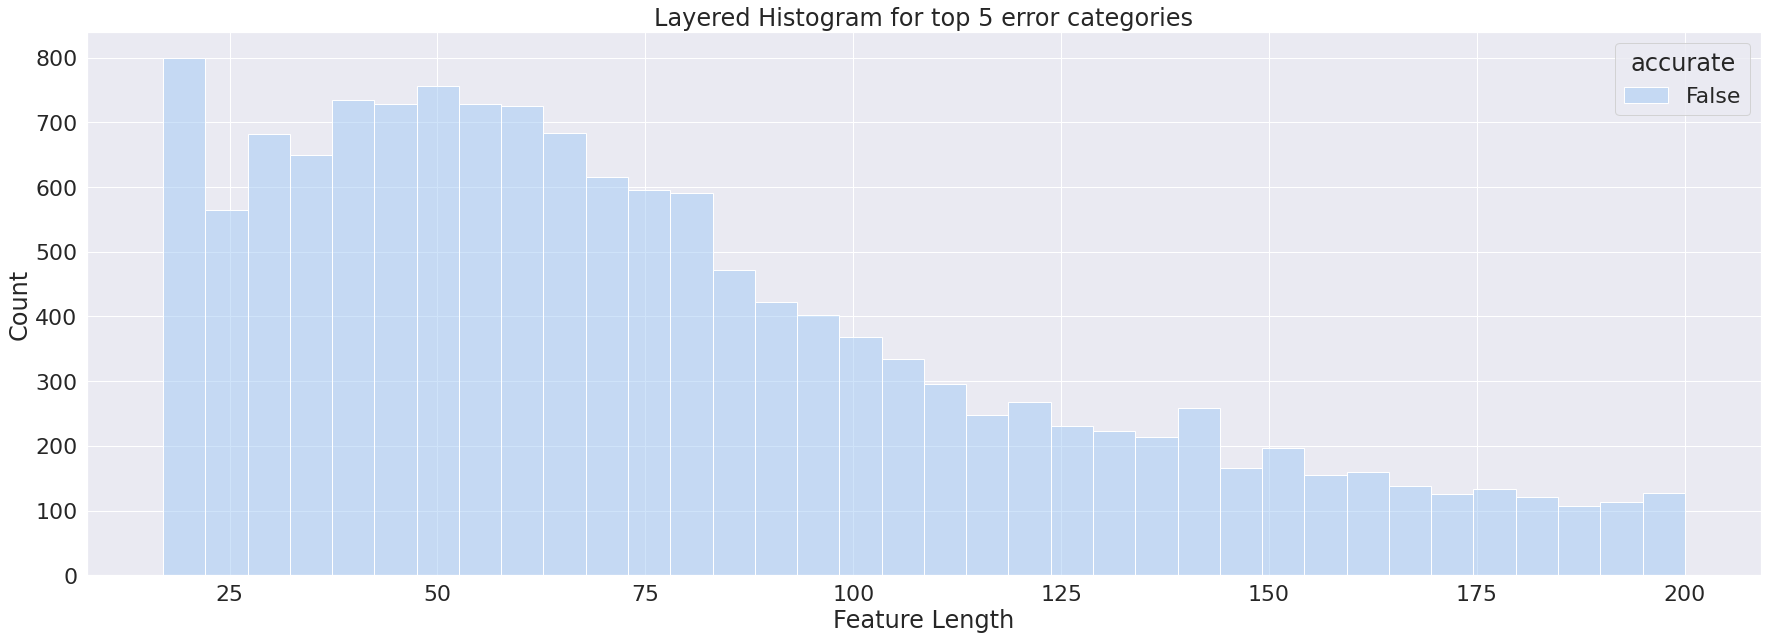

In [53]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_combined[(test_combined['MBTI Type'].isin(top_5)) & (test_combined['accurate'] == False) & (test_combined['feature_len'] <= 200) ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")

In [54]:
#let us create a error dataframe
drill_down = test_combined[(test_combined['MBTI Type'].isin(top_5)) & (test_combined['accurate'] == False) & (test_combined['feature_len'] <= 200) ]

In [55]:
#analyze occupations
drill_down['Occupation'].value_counts()

student                                                                      559
self employed                                                                335
servicenow sorceress                                                         276
retired                                                                      253
pantz                                                                        209
                                                                            ... 
stay at home mom                                                               1
professional bum                                                               1
marketing and recruiting others to market usborne books in all 50 states.      1
having fun                                                                     1
accountant                                                                     1
Name: Occupation, Length: 429, dtype: int64

In [56]:
drill_down['occu_len']=drill_down['Occupation'].str.split().str.len()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Count')

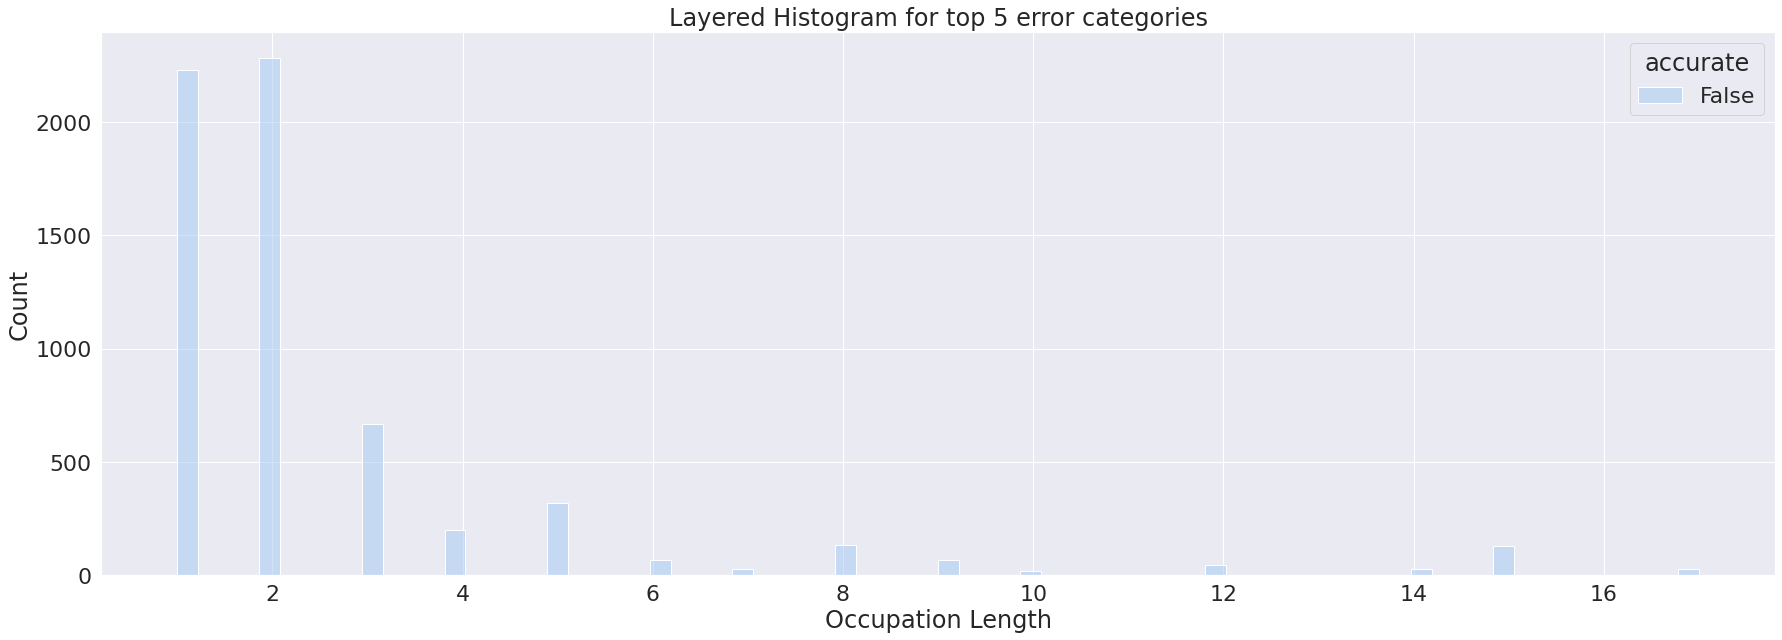

In [57]:
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=drill_down, ax=ax, stat="count", multiple="layer",
             x="occu_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Occupation Length")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

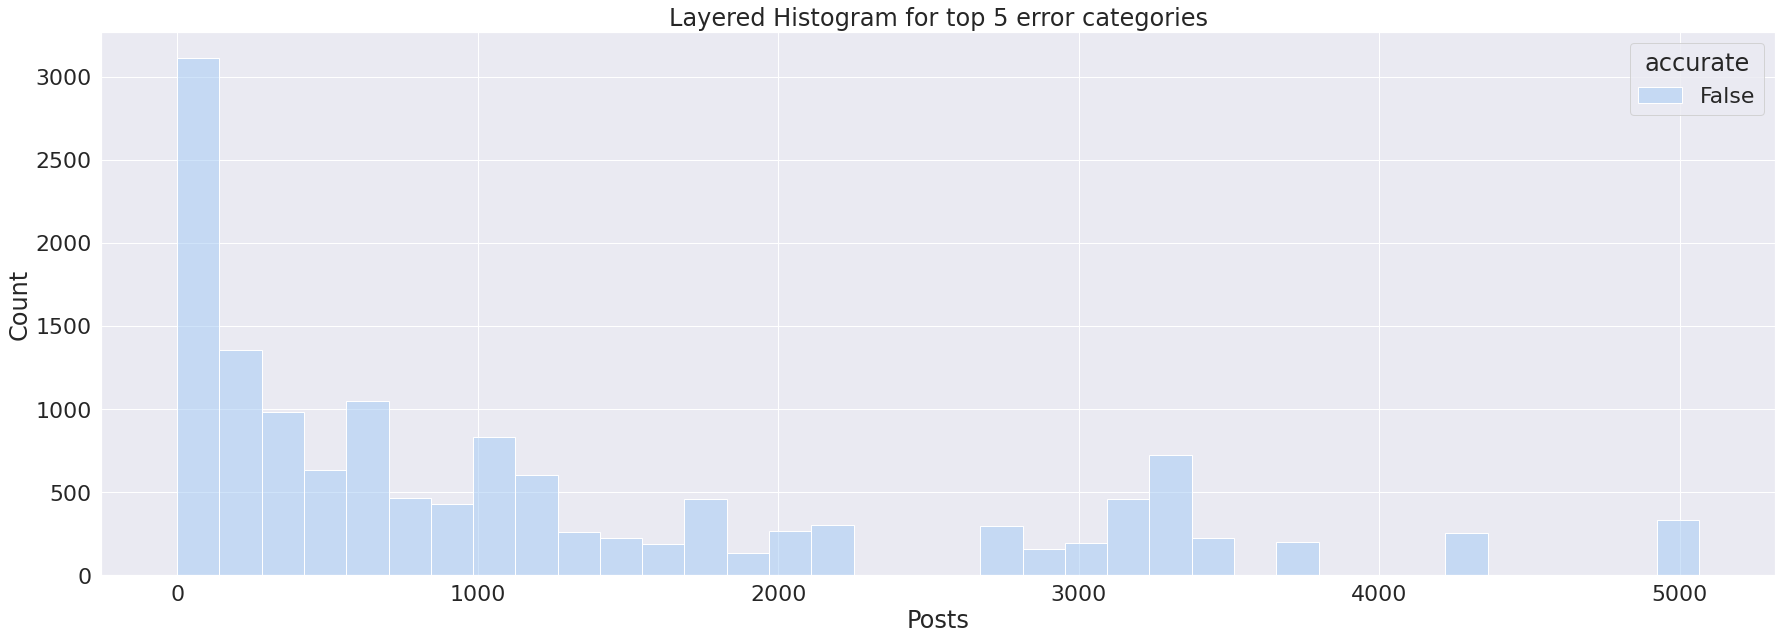

In [58]:
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=drill_down, ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

In [59]:
drill_down[drill_down['occu_len']==2]

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature,accurate,message_len,feature_len,occu_len
1400015,betty blue,45.0,5064,self employed,yes. jealousy is preemptive grief. it serve...,143486,ENFP,12,9,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,132,196,2.0
1400037,betty blue,45.0,5064,self employed,if you keep not making decisions like that y...,143471,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,25,63,2.0
1400146,evastover,23.0,77,freelance pianist,that is too freudian and slowmoving for my t...,442975,INFP,13,9,evastover SEP 23.0 SEP 77 SEP freelance pianis...,False,106,167,2.0
1400159,coll,43.0,73,mental masturbation,turnip farmer,267325,INFJ,9,13,coll SEP 43.0 SEP 73 SEP mental masturbation S...,False,2,19,2.0
1400211,icarus,35.0,26,lawyerly adventures,random thought; did man really walk to the moo...,643783,ENTP,4,6,icarus SEP 35.0 SEP 26 SEP lawyerly adventures...,False,23,72,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492904,rajah,46.0,1774,adjunct prof,my vote is for discoursus interruptus. i am ...,1096756,ENTP,4,12,rajah SEP 46.0 SEP 1774 SEP adjunct prof SEP e...,False,15,64,2.0
1492982,betty blue,45.0,5064,self employed,agreed. highly intelligent and a wonderful p...,147629,ENFP,12,15,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,7,47,2.0
1492992,betty blue,45.0,5064,self employed,when you talked about things that make you ang...,146743,ENFP,12,9,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,40,94,2.0
1493014,tyrinth,30.0,1154,college student.,i just noticed the mega today too after like a...,1513110,INFP,13,4,tyrinth SEP 30.0 SEP 1154 SEP college student....,False,35,94,2.0


Text(0, 0.5, 'Count')

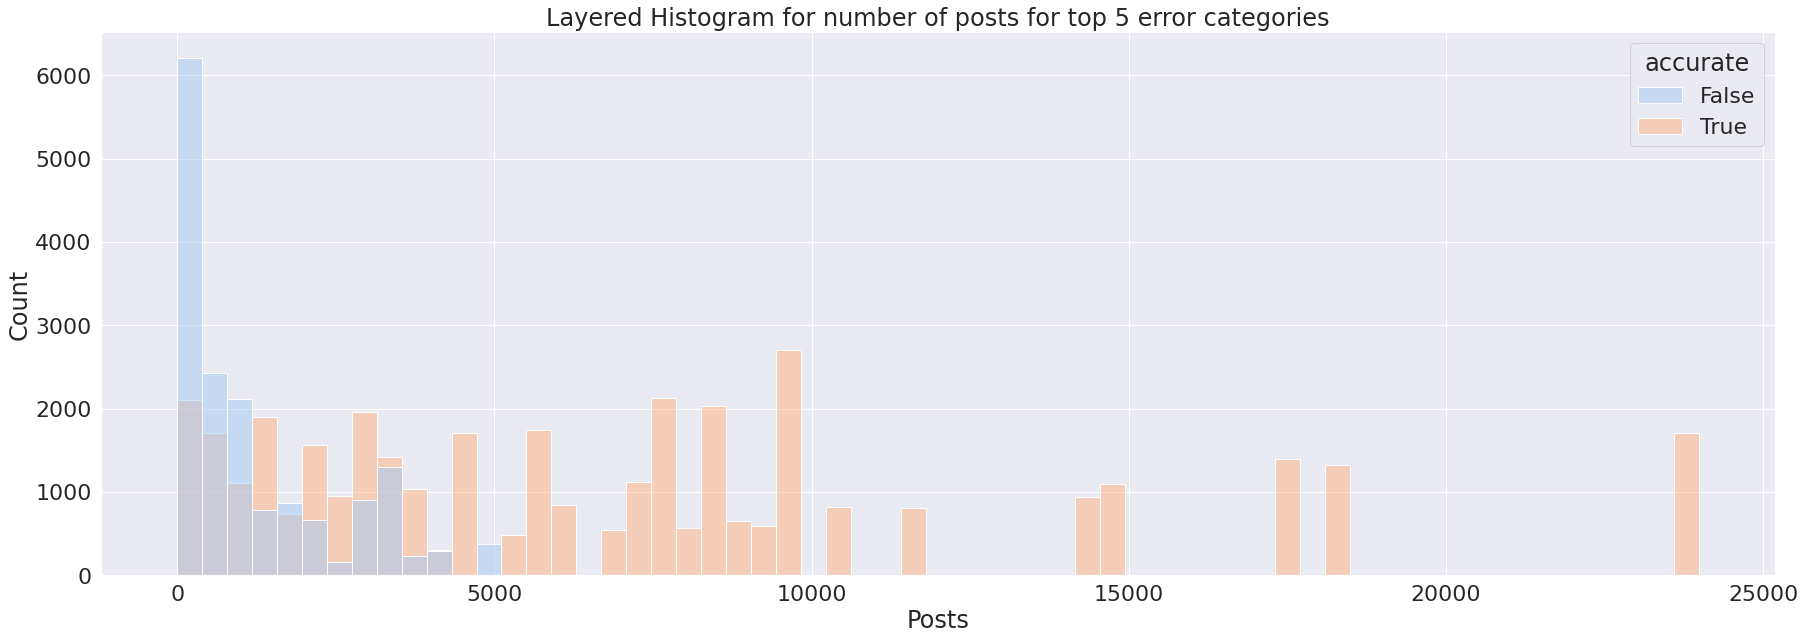

In [60]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_combined[test_combined['MBTI Type'].isin(top_5)], ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for number of posts for top 5 error categories")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

# Based on above if we have more posts from a user of certain personality types then ability to predict is better ,most of our errors are for Number of Posts less than 2500 posts

# Sample error prediction analysis

In [71]:
error_features = drill_down[:5]['feature'].to_list()

In [73]:
error_features[0]

'anonymous SEP 33.0 SEP 605 SEP None SEP emotion scores: negative 2, sadness 1, disgust 1, fear 1 SEP pos tags: space 1, intj 1, punct 6, sconj 2, adv 4, pron 3, verb 2, adp 4, det 1, noun 4, adj 4, cconj 1, aux 1, part 1 SEP   heh, why n? he comes across as an enforcer of old rules, no matter how inefficient or irrational. that does not seem very XXXX to me, more XXXX.'

In [158]:
drill_down[:5]['prediction']

1400002     9
1400015     9
1400026    13
1400032     1
1400037    15
Name: prediction, dtype: int64

In [140]:
error_proba = r3_hyp_w266_setfit_mbti.predict_proba(error_features)

In [169]:
all_errors = test_combined[(test_combined['accurate'] == False)]

In [212]:
all_errors

,Username,Age,Posts,Occupation,message,original index,MBTI Type,label,prediction,feature,accurate,message_len,feature_len
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",61435,INTP,5,9,anonymous SEP 33.0 SEP 605 SEP None SEP emotio...,False,28,78
1400014,izthe411,44.0,2585,audit,you all are missing something fundamental. if...,698931,INTJ,1,13,izthe411 SEP 44.0 SEP 2585 SEP audit SEP emoti...,False,78,138
1400015,betty blue,45.0,5064,self employed,yes. jealousy is preemptive grief. it serve...,143486,ENFP,12,9,betty blue SEP 45.0 SEP 5064 SEP self employed...,False,132,196
1400026,beargryllz,34.0,2719,None,"i do not know, i think you could be.. i know...",138989,INTP,5,13,beargryllz SEP 34.0 SEP 2719 SEP None SEP emot...,False,23,61
1400027,mae,36.0,343,accounting major,discobiscuit has been tempbanned for one month...,888534,ISTP,6,9,mae SEP 36.0 SEP 343 SEP accounting major SEP ...,False,25,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493080,super,68.0,202,None,i majored in ir/comparative..i am well aware...,1364638,ENTP,4,13,super SEP 68.0 SEP 202 SEP None SEP emotion sc...,False,128,194
1493082,aufs klo,33.0,191,student,"yeah, and in typical new jersey style, there i...",113538,ENFP,12,6,aufs klo SEP 33.0 SEP 191 SEP student SEP emot...,False,17,58
1493084,srt,33.0,174,student,..what does it say about me that i relate so...,1349253,INFP,13,6,srt SEP 33.0 SEP 174 SEP student SEP emotion s...,False,17,61
1493088,samuel de mazarin,37.0,1026,student,actually.. no.. did i miss an important refe...,1206480,ENTP,4,3,samuel de mazarin SEP 37.0 SEP 1026 SEP studen...,False,8,48


In [176]:
error_proba = r3_hyp_w266_setfit_mbti.predict_proba(all_errors['feature'].tolist())

In [182]:
error_proba[0]

array([0.01523046, 0.02116845, 0.01413133, 0.01424293, 0.03773905,
       0.02655671, 0.01353732, 0.01468097, 0.27246285, 0.48217563,
       0.01548625, 0.01336923, 0.0150129 , 0.01324469, 0.01974671,
       0.01121451])

In [141]:
valid_MBTI

{'ISTJ': 0,
 'INTJ': 1,
 'ESTJ': 2,
 'ENTJ': 3,
 'ENTP': 4,
 'INTP': 5,
 'ISTP': 6,
 'ESTP': 7,
 'ISFJ': 8,
 'INFJ': 9,
 'ESFJ': 10,
 'ENFJ': 11,
 'ENFP': 12,
 'INFP': 13,
 'ISFP': 14,
 'ESFP': 15}

In [83]:
from wordcloud import WordCloud, STOPWORDS

In [90]:
correct_pred = test_combined.message[test_combined['accurate']].tolist()

In [91]:
len(correct_pred)

71165

In [92]:
wrong_pred =test_combined.message[test_combined['accurate']== False]

In [155]:
len(wrong_pred)

21941

In [118]:
def mbti_word_cloud(inlist,title,maxwords):
  comment_words = ''
  stopwords = set(STOPWORDS)
  for val in inlist:
    val = str(val)
    # split the value
    tokens = val.split() 
    comment_words += " ".join(tokens)+" "
  cloud=WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,max_words =maxwords,
                min_font_size = 10).generate(comment_words)
  plt.figure(figsize=(10,8))
  plt.imshow(cloud)
  plt.axis('off')
  plt.title(title, fontsize=13)
  plt.show()

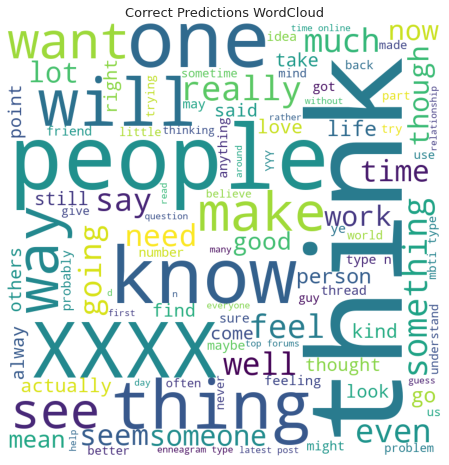

In [121]:
mbti_word_cloud(correct_pred,'Correct Predictions WordCloud',100)


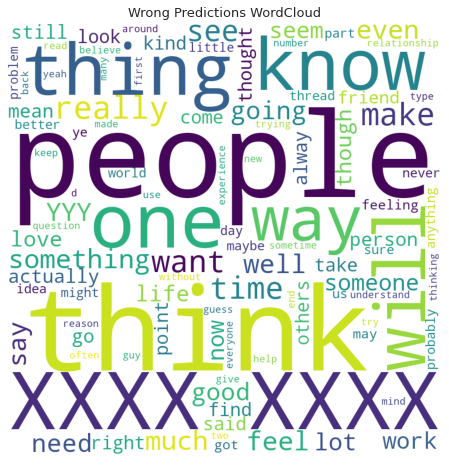

In [120]:
mbti_word_cloud(wrong_pred,'Wrong Predictions WordCloud',100)

In [132]:
wrong_items=[]
for i in wrong_pred:
  wrong_items.extend(i.split())
wrong_counter = Counter(wrong_items)

In [135]:
correct_items=[]
for i in correct_pred:
  correct_items.extend(i.split())
correct_counter = Counter(correct_items)

In [224]:
correct_counter.most_common(100)

[('i', 189462),
 ('the', 168320),
 ('to', 147078),
 ('and', 123870),
 ('a', 105767),
 ('is', 103679),
 ('of', 100640),
 ('that', 77763),
 ('not', 75409),
 ('it', 73299),
 ('you', 64635),
 ('in', 64295),
 ('have', 44123),
 ('are', 43339),
 ('for', 40268),
 ('do', 39906),
 ('my', 38722),
 ('but', 36387),
 ('with', 36183),
 ('be', 36038),
 ('as', 31569),
 ('this', 31161),
 ('am', 30286),
 ('on', 29276),
 ('or', 27998),
 ('they', 26951),
 ('was', 26584),
 ('if', 24560),
 ('like', 24049),
 ('what', 23623),
 ('would', 23390),
 ('so', 21919),
 ('just', 21703),
 ('me', 20310),
 ('about', 19741),
 ('an', 19404),
 ('at', 19066),
 ('we', 17973),
 ('can', 17698),
 ('more', 17656),
 ('your', 17652),
 ('will', 17581),
 ('think', 17512),
 ('he', 17175),
 ('people', 17175),
 ('YYY', 16589),
 ('all', 15584),
 ('when', 15465),
 ('because', 14614),
 ('from', 13817),
 ('there', 13765),
 ('one', 13401),
 ('XXXX', 13113),
 ('how', 12934),
 ('some', 12593),
 ('who', 12258),
 ('she', 12206),
 ('their', 11945)

In [220]:
wrong_counter.most_common(100)

[('i', 60577),
 ('the', 52220),
 ('to', 46140),
 ('and', 38349),
 ('a', 33418),
 ('is', 31967),
 ('of', 31623),
 ('that', 24334),
 ('not', 23029),
 ('it', 22205),
 ('you', 20388),
 ('in', 19876),
 ('have', 13879),
 ('are', 13694),
 ('my', 12848),
 ('for', 12667),
 ('do', 12214),
 ('with', 11166),
 ('but', 11165),
 ('be', 11001),
 ('am', 9770),
 ('as', 9670),
 ('this', 9486),
 ('on', 9081),
 ('was', 8665),
 ('or', 8559),
 ('they', 8249),
 ('if', 7544),
 ('what', 7496),
 ('like', 7316),
 ('would', 7153),
 ('so', 6855),
 ('just', 6806),
 ('an', 6587),
 ('me', 6581),
 ('about', 6084),
 ('at', 5996),
 ('he', 5688),
 ('your', 5614),
 ('can', 5601),
 ('will', 5522),
 ('more', 5504),
 ('think', 5439),
 ('we', 5385),
 ('people', 5346),
 ('YYY', 5331),
 ('when', 4916),
 ('all', 4903),
 ('XXXX', 4874),
 ('because', 4473),
 ('there', 4410),
 ('from', 4304),
 ('how', 4137),
 ('one', 4103),
 ('some', 4015),
 ('get', 3969),
 ('who', 3910),
 ('out', 3797),
 ('by', 3768),
 ('she', 3620),
 ('their', 360

In [227]:
overlap = Counter()
overlap = correct_counter & wrong_counter

In [230]:
overlap.most_common(100)

[('i', 60577),
 ('the', 52220),
 ('to', 46140),
 ('and', 38349),
 ('a', 33418),
 ('is', 31967),
 ('of', 31623),
 ('that', 24334),
 ('not', 23029),
 ('it', 22205),
 ('you', 20388),
 ('in', 19876),
 ('have', 13879),
 ('are', 13694),
 ('my', 12848),
 ('for', 12667),
 ('do', 12214),
 ('with', 11166),
 ('but', 11165),
 ('be', 11001),
 ('am', 9770),
 ('as', 9670),
 ('this', 9486),
 ('on', 9081),
 ('was', 8665),
 ('or', 8559),
 ('they', 8249),
 ('if', 7544),
 ('what', 7496),
 ('like', 7316),
 ('would', 7153),
 ('so', 6855),
 ('just', 6806),
 ('an', 6587),
 ('me', 6581),
 ('about', 6084),
 ('at', 5996),
 ('he', 5688),
 ('your', 5614),
 ('can', 5601),
 ('will', 5522),
 ('more', 5504),
 ('think', 5439),
 ('we', 5385),
 ('people', 5346),
 ('YYY', 5331),
 ('when', 4916),
 ('all', 4903),
 ('XXXX', 4874),
 ('because', 4473),
 ('there', 4410),
 ('from', 4304),
 ('how', 4137),
 ('one', 4103),
 ('some', 4015),
 ('get', 3969),
 ('who', 3910),
 ('out', 3797),
 ('by', 3768),
 ('she', 3620),
 ('their', 360

# There are no clear indications post error analysis of the result set that they are directly driven by specific feature. It is exciting to see that by utilizaing setfit model we were able to achieve 77% accuracy on multiclass classification across 93106 observations, from training only on 1024 samples. 